In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import random as rnd

import seaborn as sns
from matplotlib import style
style.use('seaborn-pastel')

from keras.layers import Dense, Dropout, Flatten
from keras.models import Model, Sequential, load_model
from keras.utils import to_categorical
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras import regularizers
from sklearn.metrics import classification_report, confusion_matrix

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

from tqdm import tqdm_notebook

from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, RandomBrightnessContrast, 
    IAAPiecewiseAffine, IAASharpen, IAAEmboss, Flip, OneOf, Compose, Rotate, ElasticTransform
)

import random

Using TensorFlow backend.


Mounted at /content/gdrive


# **Data Mix**

---





In [2]:
cd '/content/gdrive/My Drive/Colab Notebooks/AML/mix'

/content/gdrive/My Drive/Colab Notebooks/AML/mix


In [3]:
imgs = []
labels = []
print("-- TOTAL LOAD --")
for lab in tqdm_notebook(os.listdir()):
  print("Load in {}".format(lab))
  for im in tqdm_notebook(os.listdir(lab)):
    imgs.append(cv.imread(os.path.join(lab, im)))
    labels.append(lab)

# imgs = np.array(imgs)
# labels = np.array(labels)

# imgs.shape, labels.shape

-- TOTAL LOAD --


Load in surprise


Load in angry


Load in fear


Load in sad


Load in neutral


Load in happy


Load in disgust


In [0]:
# idx = np.random.permutation(len(imgs))
# labels = labels[idx]
# imgs = imgs[idx]

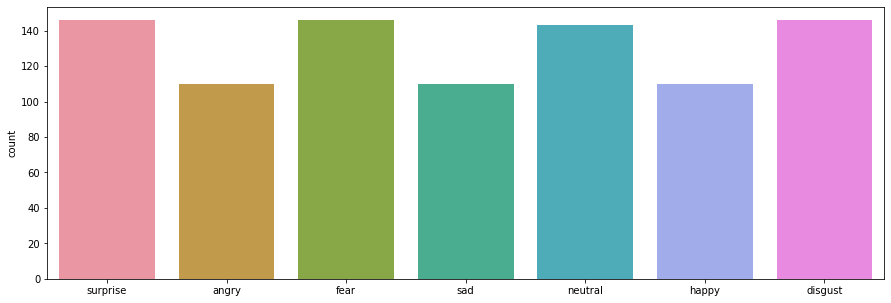

In [5]:
plt.figure(figsize = (15,5))
sns.countplot(labels)

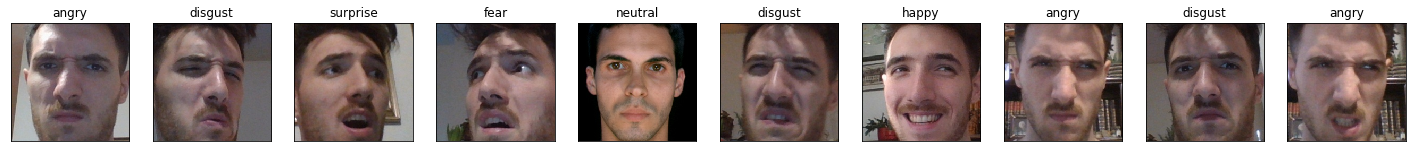

In [6]:
plt.figure(figsize=(25, 8))
nimages = 10 
for i in range(nimages):
    ax = plt.subplot(2, nimages, i + 1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    l = random.randint(0, len(labels))
    plt.imshow(cv.cvtColor(imgs[l], cv.COLOR_BGR2RGB))
    plt.title(str(labels[l]))



```
# Prepare train and test
```



In [0]:
x_train, imgs_test, y_train, y_test = train_test_split(imgs, labels, test_size = .2, random_state = 42, stratify = labels)

# **Data mix + Family**

---



In [0]:
!unzip '/content/gdrive/My Drive/Colab Notebooks/AML/mix_and_family.zip'

In [3]:
cd '/content/mix_and_family'

/content/mix_and_family


In [4]:
imgs = []
labels = []
print("-- TOTAL LOAD --")
for lab in tqdm_notebook(os.listdir()):
  print("Load in {}".format(lab))
  for im in tqdm_notebook(os.listdir(lab)):
    imgs.append(cv.imread(os.path.join(lab, im)))
    labels.append(lab)

# imgs = np.array(imgs)
# labels = np.array(labels)

# imgs.shape, labels.shape

-- TOTAL LOAD --


Load in neutral


Load in disgust


Load in sad


Load in angry


Load in happy


Load in surprise


Load in fear


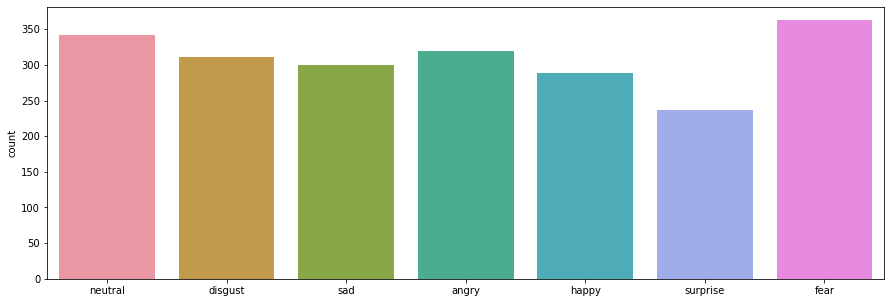

In [5]:
plt.figure(figsize = (15,5))
sns.countplot(labels)

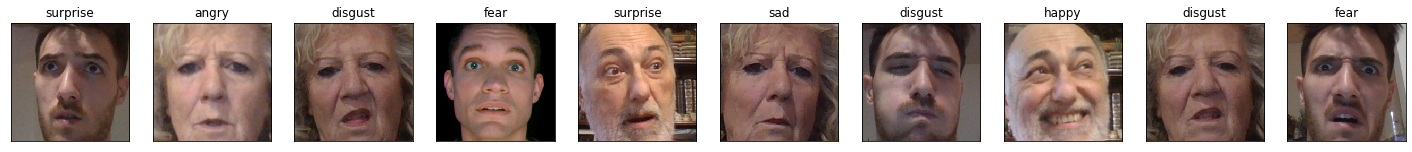

In [6]:
plt.figure(figsize=(25, 8))
nimages = 10 
for i in range(nimages):
    ax = plt.subplot(2, nimages, i + 1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    l = random.randint(0, len(labels))
    plt.imshow(cv.cvtColor(imgs[l], cv.COLOR_BGR2RGB))
    plt.title(str(labels[l]))

In [0]:
x_train, imgs_test, y_train, y_test = train_test_split(imgs, labels, test_size = .2, random_state = 42, stratify = labels)

# Data Augmentation

In [0]:
def augment(aug, image):
    return aug(image=image)['image']

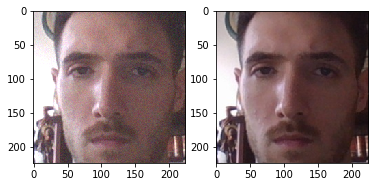

In [9]:
noise = GaussNoise(var_limit = (10,80), p = 1)
plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(augment(noise, imgs[0]), cv.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(imgs[0], cv.COLOR_BGR2RGB))

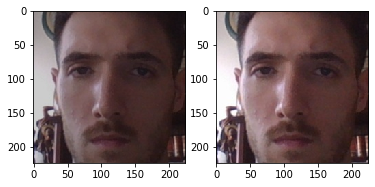

In [10]:
brightness = RandomBrightnessContrast(p=1, brightness_limit = 0.5, contrast_limit = 0.5)
plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(augment(brightness, imgs[0]), cv.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(imgs[0], cv.COLOR_BGR2RGB))

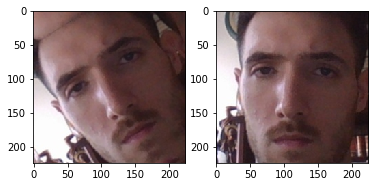

In [11]:
rotate = Rotate(p = 1, limit = (60))
plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(augment(rotate, imgs[0]), cv.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(imgs[0], cv.COLOR_BGR2RGB))

In [12]:
for i in tqdm_notebook(range(len(x_train))):
  prob = random.uniform(0, 1)
  if prob > 0.7:
    x_train.append(augment(noise, x_train[i]))
    y_train.append(y_train[i])
  prob = random.uniform(0, 1)
  if prob > 0.7:
    x_train.append(augment(brightness, x_train[i]))
    y_train.append(y_train[i])
  prob = random.uniform(0, 1)
  if prob > 0.7:
    x_train.append(augment(rotate, x_train[i]))
    y_train.append(y_train[i])

In [13]:
x_train = np.array(x_train)
y_train = np.array(y_train)

x_test = np.array(imgs_test)
y_test = np.array(y_test)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3250, 224, 224, 3), (3250,), (433, 224, 224, 3), (433,))

#**VggFace**

---




In [14]:
!pip install git+https://github.com/rcmalli/keras-vggface.git

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-_npm7a9r
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-_npm7a9r
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp36-none-any.whl size=8311 sha256=31cd8a1bc65277b316d58be2155f0d0d017194053bf67b4b28f6de090429c593
  Stored in directory: /tmp/pip-ephem-wheel-cache-yw4dvamo/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface


In [0]:
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input

In [0]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_train = to_categorical(y_train, num_classes = 7)
y_test = le.fit_transform(y_test)
y_test = to_categorical(y_test, num_classes = 7)

In [0]:
x_train = x_train.astype('float64')
x_test = x_test.astype('float64')
x_train = preprocess_input(x_train, version=2)
x_test = preprocess_input(x_test, version=2)

In [17]:
np.max(x_train), np.min(x_train), x_train.shape, np.max(x_test), np.min(x_test), x_test.shape

(163.5047,
 -131.0912,
 (3250, 224, 224, 3),
 163.5047,
 -131.0912,
 (433, 224, 224, 3))

In [18]:
base_model = VGGFace(include_top = False, input_shape = (224, 224, 3), model='senet50')

In [19]:
len(base_model.layers)

286

In [0]:
count = 1
nlayer_stop = 180
for layer in base_model.layers:
  if count <= nlayer_stop:
    count += 1
    layer.trainable = False
  else:
    break

In [21]:
base_model.summary()

Model: "vggface_senet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
____________________________________________________________________________________

In [22]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation = 'relu', kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l1(0.01)))
model.add(Dropout(.5))
model.add(Dense(256, activation = 'relu', kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l1(0.01)))
model.add(Dropout(.5))
model.add(Dense(128, activation = 'relu', kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l1(0.01)))
model.add(Dropout(.5))
model.add(Dense(7, activation = 'softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['acc'])

#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8, min_delta=0.01)

# checkpoint
filepath = "/content/gdrive/My Drive/Colab Notebooks/AML/weights-senet50-family.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [23]:
n_epochs = 100
batch_size = 128
val_split = .25

history_vggface = model.fit(x_train, y_train, epochs = n_epochs, validation_split = val_split,
                            verbose = 1, batch_size = batch_size, callbacks = callbacks_list)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 2437 samples, validate on 813 samples
Epoch 1/100
2437/2437 [==============================] - 23s 9ms/step - loss: 15.4144 - acc: 0.1436 - val_loss: 23.1733 - val_acc: 0.1550

Epoch 00001: val_acc improved from -inf to 0.15498, saving model to /content/gdrive/My Drive/Colab Notebooks/AML/weights-senet50-family.best.hdf5
Epoch 2/100
2437/2437 [==============================] - 12s 5ms/step - loss: 12.5795 - acc: 0.1449 - val_loss: 19.7675 - val_acc: 0.1550

Epoch 00002: val_acc did not improve from 0.15498
Epoch 3/100
2437/2437 [==============================] - 12s 5ms/step - loss: 10.3950 - acc: 0.1510 - val_loss: 9.2300 - val_acc: 0.1550

Epoch 00003: val_acc did not improve from 0.15498
Epoch 4/100
2437/2437 [==============================] - 11s 5ms/step - loss: 8.6373 - acc: 0.1547 - val_loss: 7.7654 - val_acc: 0.1550

Epoch 00004: val_acc did not improve from 0.15498
Epoch 5/

In [0]:
 def model_plot(history): 
  fig, axes = plt.subplots(1, 2, figsize = (25, 8))
  colors = ['coral', 'lightgreen']

  axes[0].plot(history.history['loss'], color = colors[0])
  axes[0].plot(history.history['val_loss'], color = colors[1])
  # axes[0].title('model loss')
  # axes[0].ylabel('loss')
  # axes[0].xlabel('epoch')
  axes[0].legend(['train', 'val'], loc='upper left')

  axes[1].plot(history.history['acc'], color = colors[0])
  axes[1].plot(history.history['val_acc'], color = colors[1])
  # axes[1].title('model accuracy')
  # axes[1].ylabel('accuracy')
  # axes[1].xlabel('epoch')
  axes[1].legend(['train', 'val'], loc='upper left')

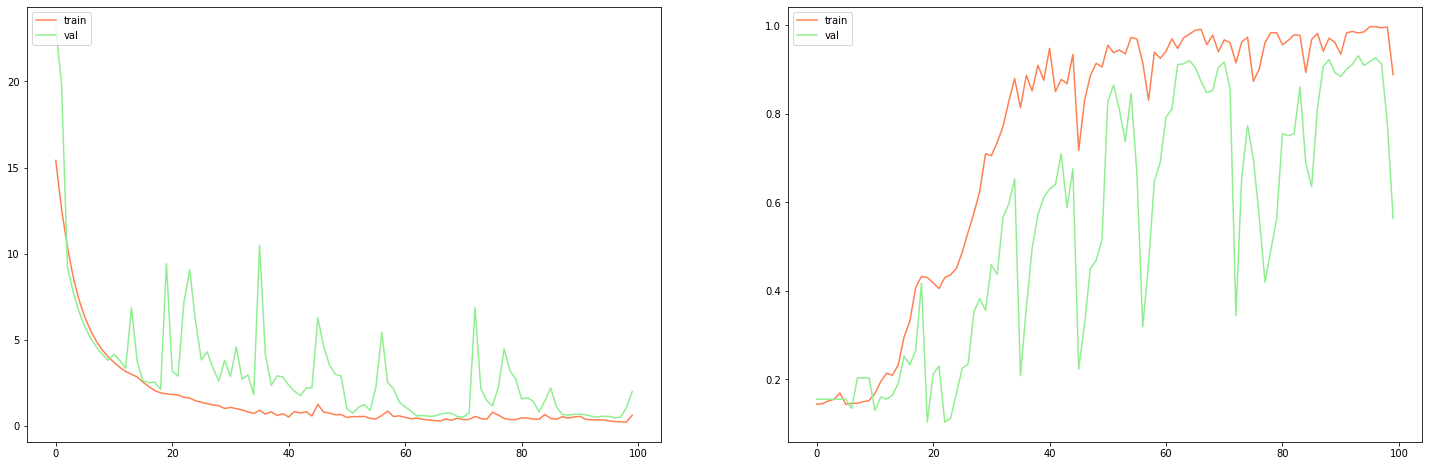

In [57]:
model_plot(history_vggface)

In [0]:
# load weights
model = load_model("/content/gdrive/My Drive/Colab Notebooks/AML/weights-senet50-family.best.hdf5")

In [44]:
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]
loss = score[0]

print("Post-training accuracy: {} %".format(round(accuracy, 3)))
print("Post-training loss: {}".format(round(loss, 4)))

433/433 [==============================] - 1s 3ms/step
Post-training accuracy: 95.381 %
Post-training loss: 0.4294


In [28]:
y_true = np.argmax(y_test,axis=1)
y_pred = model.predict_classes(x_test)
print(classification_report(y_true, y_pred, target_names = le.inverse_transform([0,1,2,3,4,5,6])))

              precision    recall  f1-score   support

       angry       0.98      0.97      0.98        64
     disgust       0.98      0.98      0.98        62
        fear       0.97      0.85      0.91        73
       happy       0.98      0.98      0.98        58
     neutral       0.96      0.97      0.96        69
         sad       0.97      1.00      0.98        60
    surprise       0.81      0.94      0.87        47

    accuracy                           0.95       433
   macro avg       0.95      0.96      0.95       433
weighted avg       0.96      0.95      0.95       433



In [0]:
lab_test = le.inverse_transform(np.argmax(y_test, axis=1))
lab_pred = le.inverse_transform(y_pred)

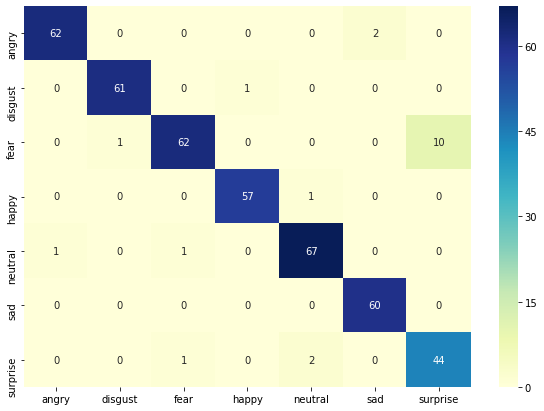

In [30]:
etichette = ['angry','disgust','fear','happy','neutral','sad','surprise']
cm = confusion_matrix(lab_test, lab_pred)
df_cm = pd.DataFrame(cm, index = etichette, columns = etichette)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, cmap="YlGnBu")

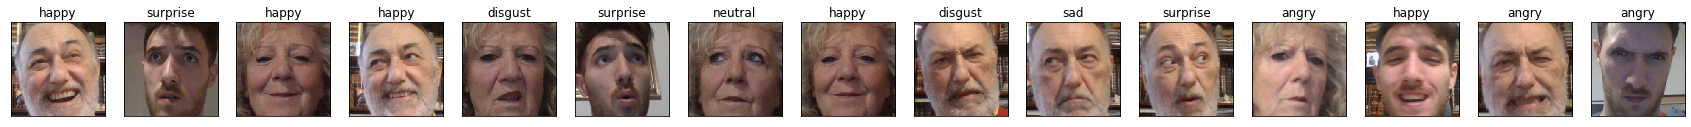

In [34]:
plt.figure(figsize=(30, 30))
nimages = 15 
for i in range(nimages):
    ax = plt.subplot(2, nimages, i + 1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    l = random.randint(0, len(lab_pred))
    plt.imshow(cv.cvtColor(imgs_test[l], cv.COLOR_BGR2RGB))
    plt.title(str(lab_pred[l]))

In [34]:
#save model and architecture to single file
#model.save("/content/gdrive/My Drive/Colab Notebooks/AML/vggface-senet50-model.h5")
print("Saved model to disk")

Saved model to disk
